# Reproduction of Sphinteract on KaggleDBQA (Ambiguity Filtered)

This notebook reproduces the three methods described in the paper "Sphinteract: ...":
1.  **Baseline (Method 1)**: Zero-shot generation with Self-Correction (Fix Invalid).
2.  **Sphinteract (Method 2)**: Interactive framework with Clarification Questions (SRA) and Feedback.
3.  **Break No Ambiguity (Method 3)**: Similar to Method 2 but with an Early Stopping mechanism.

We use the **KaggleDBQA** dataset.

**Modification**: Instead of random sampling, we filter for 20 "Ambiguous" samples using GPT-3.5-Turbo.

## Requirements
- `openai`
- `pandas`
- `sqlite3`
- `numpy`
- `python-dotenv`
- `tiktoken`
- `xxhash`

A `.env` file with `OPENAI_API_KEY` and `OPENAI_BASE_URL` (optional) is needed.


In [83]:
import nbformat as nbf
import os
import pandas as pd
import sqlite3
import numpy as np
import time
import xxhash
import json
import pickle
import sys
from openai import OpenAI
from dotenv import load_dotenv
from multiprocessing import Process, Queue
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OpenAIEmbeddings
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
import re

# Add current directory and parent directory to path to allow importing local modules
sys.path.append(os.getcwd())
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from reproduction_utils import execute_query_worker

# Load environment variables
load_dotenv(override=True)

api_key = os.getenv("OPENAI_API_KEY")
base_url = os.getenv("OPENAI_BASE_URL")

if not api_key:
    raise ValueError("Please set OPENAI_API_KEY in your .env file.")

client = OpenAI(
    api_key=api_key,
    base_url=base_url if base_url else "https://api.openai.com/v1"
)

# Initialize Vectorstore for Few-Shot
try:
    embeddings = OpenAIEmbeddings(openai_api_key=api_key)
    if os.path.exists("./userstudy_chroma"):
        vectorstore = Chroma(persist_directory="./userstudy_chroma", embedding_function=embeddings)
        print("Vectorstore loaded successfully.")
    else:
        print("Warning: userstudy_chroma directory not found. Few-shot retrieval may fail.")
        vectorstore = None
except Exception as e:
    print(f"Error loading vectorstore: {e}")
    vectorstore = None

print("Environment setup complete.")

Environment setup complete.


In [84]:
from pathlib import Path
import os
import pandas as pd

DATASET_FILENAME = os.getenv('DATASET_FILENAME', 'kaggle_dataset.csv')
KAGGLE_DATASET_PATH = os.getenv('KAGGLE_DATASET_PATH')

def resolve_dataset_path():
    if KAGGLE_DATASET_PATH:
        p = Path(KAGGLE_DATASET_PATH).expanduser()
        if p.exists():
            return p
    p2 = Path(DATASET_FILENAME).expanduser()
    if p2.exists():
        return p2
    p3 = resolve_file(DATASET_FILENAME)
    return p3

dataset_p = resolve_dataset_path()
if dataset_p is None:
    print('kaggle_dataset.csv not found. Set KAGGLE_DATASET_PATH or place file under data/datasets.')
    df = pd.DataFrame()
    print(f'Loaded {len(df)} records.')
else:
    dataset_path = str(dataset_p)
    df = pd.read_csv(dataset_path)
    print(f'Loaded {len(df)} records from {dataset_path}')


kaggle_dataset.csv not found. Set KAGGLE_DATASET_PATH or place file under data/datasets.
Loaded 0 records.


## Helper Functions

In [85]:
# Helper Functions

In [102]:
def clean_query(sql_query):
    # Remove markdown code blocks
    pattern = r"```sql(.*?)```"
    match = re.search(pattern, sql_query, re.DOTALL | re.IGNORECASE)
    if match:
        sql_query = match.group(1)
    else:
        sql_query = sql_query.replace("```sql", '').replace("```", '')

    sql_query = sql_query.replace(';', '')
    sql_query = sql_query.replace('"""', '')
    
    # Find the start of the SQL statement (SELECT or WITH)
    match_select = re.search(r'\bSELECT\b', sql_query, re.IGNORECASE)
    match_with = re.search(r'\bWITH\b', sql_query, re.IGNORECASE)
    
    start_index = -1
    if match_with and match_select:
        start_index = min(match_with.start(), match_select.start())
    elif match_with:
        start_index = match_with.start()
    elif match_select:
        start_index = match_select.start()
        
    if start_index != -1:
        sql_query = sql_query[start_index:]
    else:
        # If no SELECT/WITH found, assume it's a completion and prepend SELECT
        # But ensure we don't double prepend if the user output " * FROM ..."
        if 'FROM' in sql_query.upper():
             sql_query = 'SELECT ' + sql_query
        else:
             # Fallback: just prepend SELECT
             sql_query = 'SELECT ' + sql_query
             
    return sql_query.strip()

def generate_db_schema(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = cursor.fetchall()
    schemas = []
    for table in tables:
        if table[0] == 'sqlite_sequence':
            continue
        cursor.execute(f"SELECT sql FROM sqlite_master WHERE type='table' AND name='{table[0]}'")
        create_prompt = cursor.fetchone()[0]
        schemas.append(create_prompt)
    conn.close()
    return "\n\n".join(schemas)

def evalfunc(sql_source, sql_target, db_path):
    if not os.path.isfile(db_path):
        return False, [FileNotFoundError(f"Database not found: {db_path}")]
    
    timeout = 30 # seconds
    output = Queue()
    p = Process(target=execute_query_worker, args=(db_path, sql_source, output))
    p.start()
    
    try:
        source_results = output.get(timeout=timeout)
        p.join()
        if isinstance(source_results, Exception):
            return False, [source_results]
    except Exception as e:
        p.terminate()
        return False, [e]
        
    # Execute Gold SQL (Target) - assumed safe and fast
    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        target_results = cursor.execute(sql_target).fetchall()
        conn.close()
    except Exception as e:
        return False, [e]

    # Compare results
    if len(source_results) != len(target_results):
        return False, []
        
    # Heuristic comparison (order-independent if no ORDER BY, else strict)
    if 'ORDER BY' in sql_target.upper():
        return source_results == target_results, []
    else:
        # Sort both by a stable key (str representation)
        s_sorted = sorted(list(source_results), key=lambda x: str(x))
        t_sorted = sorted(list(target_results), key=lambda x: str(x))
        return s_sorted == t_sorted, []

def LLM_generation(prompt, model='gpt-3.5-turbo', temperature=0.0, retries=3, retry_delay=1.5, log_each_retry=False, fallback_models=None):
    last_err = None
    models_to_try = [model]
    if fallback_models is None:
        fallback_models = [os.getenv("AMBIGUITY_MODEL", "gpt-4o-mini"), "gpt-4o"]
    for m in fallback_models:
        if m not in models_to_try:
            models_to_try.append(m)
    for try_model in models_to_try:
        for attempt in range(retries):
            try:
                response = client.chat.completions.create(
                    model=try_model,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=temperature,
                    max_tokens=4096
                )
                return response.choices[0].message.content.strip(), 0.0
            except Exception as e:
                last_err = e
                err_str = str(e)
                l = err_str.lower()
                if "502" in err_str or "bad gateway" in l:
                    err_label = "502 Bad Gateway"
                elif "429" in err_str or "too many requests" in l or "rate limit" in l:
                    err_label = "rate_limit"
                elif "timeout" in l or "timed out" in l:
                    err_label = "timeout"
                elif "connection reset" in l or "reset by peer" in l:
                    err_label = "conn_reset"
                elif "ssl" in l:
                    err_label = "ssl_error"
                elif "unauthorized" in l or "401" in err_str:
                    err_label = "unauthorized"
                elif "model" in l and "not found" in l:
                    err_label = "model_not_found"
                else:
                    err_label = "error"
                if log_each_retry:
                    print(f"LLM error ({err_label}), retry {attempt+1}/{retries}")
                time.sleep(retry_delay * (1.5 ** attempt))
    if last_err is not None:
        err_str = str(last_err)
        l = err_str.lower()
        if "502" in err_str or "bad gateway" in l:
            err_label = "502 Bad Gateway"
        elif "429" in err_str or "too many requests" in l or "rate limit" in l:
            err_label = "rate_limit"
        elif "timeout" in l or "timed out" in l:
            err_label = "timeout"
        elif "connection reset" in l or "reset by peer" in l:
            err_label = "conn_reset"
        elif "ssl" in l:
            err_label = "ssl_error"
        elif "unauthorized" in l or "401" in err_str:
            err_label = "unauthorized"
        elif "model" in l and "not found" in l:
            err_label = "model_not_found"
        else:
            err_label = "error"
        print(f"LLM error ({err_label}); giving up")
    return "SELECT * FROM error", 0.0

## Prompts

In [87]:
# Prompts (Aligned with FewShotAmbSQL.ipynb)

In [88]:
SRA = """/* Ask the user a new multiple choice clarification question to help you find the correct SQL answer for the following question: */
{question}
/* Given the following database schema: */
{schema}
/* And the following incorrect sql answers: */
{sqls}
/* And the following previous clarification questions and user replies: */
{cqs}

/* Consider the following ambiguity categories:
    - AmbQuestion: Is the question itself ambiguous?
    - AmbTableColumn: Is there ambiguity in mapping the entities from the QUESTION to tables and columns in the DATABASE SCHEMA?
    - AmbOutput: What fields and how many fields should be included in the output table?
    - AmbValue: What predicate value should be used to filter results?
*/

/* The clarification question should be easy to understand for people with no coding experience. */

/* Let's think step by step to generate the helpful multiple choice clarification question.
1. Summarize the clear information based on previous clarification questions and incorrect queries.
2. Evaluate whether AmbQuestion, AmbTableColumn, AmbOutput, and AmbValue remain in formulating an SQL query, considering each category individually.
3. Ask a new multiple-choice question to address the remaining ambiguities and assist in identifying the correct SQL query. Use format: mul_choice_cq = "".
4. Prioritize granularity alignment and valid join keys; avoid suggesting joins across incompatible levels (e.g., district vs state) or metrics that cannot be computed at a common grain.
*/
"""

SRA_ES = """/* Ask the user a new multiple choice clarification question to help you find the correct SQL answer for the following question: */
{question}
/* Given the following database schema: */
{schema}
/* And the following incorrect sql answers: */
{sqls}
/* And the following previous clarification questions and user replies: */
{cqs}

/* Consider the following ambiguity categories:
    - AmbQuestion: Is the question itself ambiguous?
    - AmbTableColumn: Is there ambiguity in mapping the entities from the QUESTION to tables and columns in the DATABASE SCHEMA?
    - AmbOutput: What fields and how many fields should be included in the output table?
    - AmbValue: What predicate value should be used to filter results?
*/

/* The clarification question should be easy to understand for people with no coding experience. */

/* Let's think step by step to generate the helpful multiple choice clarification question.
1. Summarize the clear information based on previous clarification questions and incorrect queries.
2. Evaluate whether AmbQuestion, AmbTableColumn, AmbOutput, and AmbValue remain in formulating an SQL query, considering each category individually.
3. If no remaining ambiguities are identified, then output "NO AMBIGUITY".
   Else, ask a new multiple-choice question to address the remaining ambiguities and assist in identifying the correct SQL query. Use format: mul_choice_cq = "".
4. Prioritize granularity alignment and valid join keys; avoid suggesting joins across incompatible levels (e.g., district vs state) or metrics that cannot be computed at a common grain.
*/
"""

sql_generation_v2 = """/* Given the following database schema: */
{schema}
/* And the following incorrect sql answers: */
{sqls}
/* And the following user replies to help you write the correct sql query: */
{cqas}

{metadata}
/* Answer the following with no explanation: {question} */
/* Output ONLY SQL wrapped in a markdown block: ```sql */
"""

fix_invalid_v1 = """/* Given the following database schema: */
{schema}
/* And the following inexecutable sql query */
{invalidSQL}
/* And the following exception message */
{ex}

/* Fix the exception and write a new executable SQL query with no explanation */
/* Output ONLY SQL wrapped in a markdown block: ```sql */
"""

sql_generation_selfdebug = """/* Given the following database schema: */
{schema}
/* And the following incorrect sql answers: */
{sqls}

{metadata}
/* Answer the following with no explanation: {question} */
/* Output ONLY SQL wrapped in a markdown block: ```sql */
"""

def build_metadata_constraints(nlq, schema):
    s_lower = schema.lower()
    n_lower = nlq.lower()
    cons = []
    cons.append("Constraints: SQL must be executable on the given schema and use a single consistent granularity across tables.")
    cons.append("When tables differ in granularity, aggregate to a common key before joining; do not join district/school rows directly to state-level aggregates.")
    cons.append("Use only valid join keys present in the schema with matching types; prefer exact equality joins.")
    cons.append("If feedback conflicts with these constraints, follow the constraints.")
    if ("finrev_fed_17" in s_lower) and ("ndecorexcel_math_grade8" in s_lower):
        cons.append("For FINREV_FED_17 with NDECoreExcel_Math_Grade8, compute metrics at state+year granularity: aggregate revenue by state_code and yr_data, join with NDECoreExcel_Math_Grade8 state and year; do not select district-level columns unless scores exist at the same granularity.")
    if ("resultsdata15" in s_lower) and ("lod" in s_lower or "limit of detection" in n_lower):
        cons.append("For 'easiest to be tested' tasks, use the pesticide with lowest average LOD; if LOD is unavailable, use the highest count of test records.")
    meta = "\n".join([f"/* {c} */" for c in cons])
    return meta

cq_prefix_v1 = '''/* some examples are provided */
/* example question: */
Which artist/group is most productive?
/* example previous clarification questions and user replies: */
clarification questions: How to rank artist/group productivity? a) rank by the number of records produced, b) rank by the total number of downloads, c) other (please specify).
user: b) rank by the total number of downloads```
/* example reasoning and remaining ambiguity type*/
It is clear that the SQL answer should use ORDER BY and LIMIT 1 based on the sum of total downloads. However, it is unclear what columns should be used to represent the 'artist/group'.  Both the `artist` and the `groupName` columns contain information about 'artist/group'. ’‘AmbTableColumn’ remains.
/* example clarification question */
mul_choice_cq = "Which columns represent the 'artist/group' information? a) the artist column only, b) the groupName column only, c) both the artist column and the groupName column, d) other (please specify).”```

/* example question: */
Which Premier League matches ended in a draw in 2016?
/* example previous clarification questions and user replies: */
clarification questions: Is the year '2016' referring to? a) season is 2016, b) season is either 2015/2016 or 2016/2017, c) the date time is at year 2016, d) other (specify).
user: a) season is 2016,
clarification questions: How to find the 'Premier league'? a) consider all leagues, b) consider only the league with name 'Premier League', c) other (specify).
user: b) consider only the league with name 'Premier League'
/* example reasoning and remaining ambiguity type*/
It is clear that the SQL answer to this question needs to contain a WHERE clause for three conditions: 'Premier League', 'draw', and 'in 2016'. However, the question did not specify what fields should be contained in the output table. 'AmbOutput' remains.
/* example clarification question */
mul_choice_cq = “What fields represent the target 'matches'? a) all fields from football data table, b) the `league` column, c) other (specify).”

/* example question: */
Which type of crime has the highest rate of ‘Investigation complete’?
/* example previous clarification questions and user replies: */
No previous clarification questions.
/* example reasoning and remaining ambiguity type*/
It is clear that the SQL answer to this question needs to contain a WHERE clause to find crimes that have 'Investigation complete' outcomes, uses ORDER BY and LIMIT 1 to find the type of crime with the highest rate, and the output table has only one row. However, it needs to be clarified i) what predicate value should be used for 'Investigation complete', and ii) how to represent the 'rate', and iii) if the output table contains only the crime type column or the crime type column with the highest rate aggregate. Hence, this question is ambiguous because of 'AmbVal', 'AmbQuestion', and ‘AmbOutput’.
/* example clarification question */
mul_choice_cq = “What information should be used to find 'Investigation complete'? a) see if outcome contains the phrase 'Investigation complete', b)  see if outcome is 'Investigation complete; no suspect identified', c) other (please specify).”

/* example question: */
For award winners, which position has the most hall of fame players?
/* example previous clarification questions and user replies: */
clarification questions: How should the 'position' for players be identified? a) by the `award_id` column, b) by the `category` column, c) other (please specify).
user: c)  by the `note` column
/* example reasoning and remaining ambiguity type*/
It is clear that the answer should use the `note` column for player ‘positions’. However, it is unclear what fields should contain in the output table. Hence ‘AmbOutput’ remains.
/* example clarification question */
mul_choice_cq = “What fields should be contained in the output table? a) one field: the position, b) two fields: the position and the number of hall-of-fame players, c) other (please specify).”

/* example question: */
How many Wisconsin school districts receive federal funding?
/* example previous clarification questions and user replies: */
clarification question: How to determine if a district has received federal funding? a) based on the t_fed_rev is larger than 0, b) the answer does not need to consider this aspect, c) other (please specify).
user: c) every school in `FINREV_FED_17` table has received federal funding.
/* example reasoning and remaining ambiguity type*/
It is clear that every school in `FINREV_FED_17` table have received federal funding. However, it is unclear if the word ‘Wisconsin’ refers to the state or the school district. Hence, ‘AmbQuestion’ remains.
/* example clarification question */
mul_choice_cq = “Is 'Wisconsin school districts' referring to? a) all school districts in the state Wisconsin, b) school districts with names that contain Wisconsin, c) other (please specify).”

/* example question: */
How many 2-year public schools are there in "California"?
/* example previous clarification questions and user replies: */
clarification question: Which column(s) should be used to find ‘2-year public schools’? a) `level` column, b) `control` column, c) other (please specify).
user: c) use both `level` and `control` columns to find ‘2-year public schools’ information.
/* example reasoning and remaining ambiguity type*/
It is clear that the correct SQL answer should have a WHERE clause with filters based on the `level` and `control` columns. However, it is unclear what predicate values should be used for these two columns. Hence, ‘AmbValue’ remains.
/* example clarification question */
mul_choice_cq = “What predicate values should be used for the `level` and `control` columns to find  ‘2-year public schools’? a) ‘2-year’ and ‘public’ b) ‘2’ and ‘public, c) other (please specify)’.” 

/* example question: */
Calculate the total beat of the crimes reported in a community area in the central side with a population of 50,000 and above.
/* example previous clarification questions and user replies: */
clarification question: What column and predicate value should be used to determine ‘central side’? a) Column `side` in table `Community_Area` with value ‘central’, b) Column `side` in table `Community_Area` with value ‘Central’, c) other (please specify).
user: b) Column `side` in table `Community_Area` with value ‘Central’
/* example reasoning and remaining ambiguity type*/
It is clear that the output table should contain a single number and use the predicate ‘Central’ in `Community_Area`.`side`; However, it is not clear which column of statistics is ‘total beat’ referring to. Hence, AmbTableColumn remains.
/* example clarification question */
mul_choice_cq = “Which column is related to ‘total beat’? a) `Crime`.`beat`, b) `Crime`.`report_no`, c) other (please specify).”

/* example question: */
Of all the nonessential genes that are not of the motorprotein class and whose phenotype is cell cycle defects, how many do not have a physical type of interaction?
/* example previous clarification questions and user replies: */
No previous clarification questions.
/* example reasoning and remaining ambiguity type*/
It is clear that ‘phenotype’ is referring to the `Phenotype` column, ‘motorprotein class’ is referring to the `class` column, ‘nonessential genes’ is referring to the `essential` column, and `physical type` is referring to the `type` column. However, it is unclear what fields should be contained in the output table, and hence ‘AmbOutput’ remains.
/* example clarification question */
mul_choice_cq = “What fields should be included in the output table? a) One column for the number of genes b) Two columns for GeneID and physical type c) Other (please specify).”
\n\n
'''

feedback_v2 = """/* Given the following Natural Language Question: */
{nlq}
/* And the following Gold Query: */
{query}
/* Answer the following multiple choice clarification question truthfully based on the Gold Query: */
{question}

/* Follow these steps:
1. Identify which portion of the Gold Query answers the clarification question.
2. Evaluate the correctness of each multiple choice answer based only on the Gold Query.
3. If none of the choices are correct or you select "other (please specify)", provide a short answer for the clarification question.
4. Output the final answer in the format: answer_to_cq = "".

Let's proceed step by step. */
/* Only use information from the Gold Query; do not guess.
   Prefer answers that maintain consistent granularity and valid join semantics. */
"""

feedback_prefix_v1='''/* some examples are provided */
/* example question: */
How many acres burned in fires in California each year between 2000 and 2005?
/* example gold sql query*/
SELECT\n  SUM(FIRE_SIZE),\n  FIRE_YEAR\nFROM Fires\nWHERE\n  State = "CA" AND FIRE_YEAR BETWEEN 2000 AND 2005\nGROUP BY\n  FIRE_YEAR
/* example clarification question*/
What information should the output table contain? a) two columns: the total acres burned and the year, b) one column: the total acres burned for each year, c) one column: the total acres burned across all target years, d) other (please specify).
/* example reasoning */
Output table is determined by the SELECT clause in the gold sql query. The gold query uses ‘SELECT  SUM(FIRE_SIZE), FIRE_YEAR’. As a result, the output table has two columns, the total acres burned and the year. Hence, choice a is correct.
/* example  answer*/
answer_to_cq = "a) two columns: the total acres burned and the year"

/* example question: */
What was the most common cause of fire between 2000 and 2005?
/* example gold sql query*/
SELECT\n  STAT_CAUSE_DESCR\nFROM Fires\nWHERE\n  FIRE_YEAR BETWEEN 2000 AND 2005\nGROUP BY\n  STAT_CAUSE_DESCR\nORDER BY\n  COUNT(*) DESC\nLIMIT 1;
/* example clarification question*/
Which information should be used to represent the 'cause of fire'? a) the code that represents the cause, b) the description of the cause, c) both the code and the description of the cause, d) other (please specify).
/* example reasoning */
The clarification question is asking for which column should be used to represent the cause of fire. The gold query uses the STAT_CAUSE_DESCR to represent the cause. As a result, choice b is correct.
/* example  answer*/
answer_to_cq = "b) the description of the cause"

/* example question: */
Whose CDs sells best?
/* example gold sql query*/
SELECT\n  artist\nFROM torrents\nGROUP BY\n  artist\nORDER BY\n  SUM(totalSnatched) DESC\nLIMIT 1;
/* example clarification question*/
Which column should be used to identify music related to 'CD'? a) groupName, b) tag, c) releaseType, d) other (please specify)
/* example reasoning */
The gold query does not use a WHERE clause to filter the CDs. Hence, the CD information is not contained in the tag column or the release type column. As a result, choice a, b, and c are all wrong.
/* example  answer*/
answer_to_cq = “d) Consider all music; No filter on ‘CD’ ”

/* example question: */
How many people wrote comments for the question "Any additional notes or comments."? */
/* example gold sql query*/
SELECT COUNT(T1.UserID) FROM Answer AS T1 INNER JOIN Question AS T2 ON T1.QuestionID = T2.questionid WHERE T2.questiontext LIKE 'Any additional notes or comments' AND T1.AnswerText IS NOT NULL
/* example clarification question*/
How to determine if a user has provided comments? a) no check needed, b) see if `AnswerText` column has empty string, c) other (please specify).
/* example reasoning */
In the gold SQL query, it checks “T1.AnswerText IS NOT NULL”. Hence, choice a and b are both wrong.
/* example  answer*/
answer_to_cq = "c) ‘wrote comments’ imply `AnswerText` is not a NULL value".

/* example question: */
Calculate the difference between the number of customers and the number of subscribers who did the trip in June 2013. 
/* example gold sql query*/
SELECT SUM(IIF(subscription_type = 'Subscriber', 1, 0)) - SUM(IIF(subscription_type = 'Customer', 1, 0)) FROM trip WHERE start_date LIKE '6/%/2013%'
/* example clarification question*/
What predicate value should be used to determine a trip in June 2013? a) start_data > 06/2013, b) start_data = ‘June 2013’, c) other (please specify).
/* example reasoning */
The gold sql query uses start_date LIKE '6/%/2013%' to find trips in June 2013.
/* example  answer*/
answer_to_cq = "c) start_date LIKE '6/%/2013%'"


/* example question: */
Identify the players who weigh 120 kg.
/* example gold sql query*/
SELECT T2.PlayerName FROM weight_info AS T1 INNER JOIN PlayerInfo AS T2 ON T1.weight_id = T2.weight WHERE T1.weight_in_kg = 120
/* example clarification question*/
What fields should be contained in the output? a) one column of player name, b) one column of player id, c) two columns of player name and player ids, d) other (please specify).
/* example reasoning */
The gold query selects ‘SELECT T2.PlayerName’. Hence, a is correct.
/* example  answer*/
answer_to_cq = "a) one column of player name"

/* example question: */
How many reviews are created for the podcast "Scaling Global" under?
/* example gold sql query*/
SELECT COUNT(T2.content) FROM podcasts AS T1 INNER JOIN reviews AS T2 ON T2.podcast_id = T1.podcast_id WHERE T1.title = 'Scaling Global'
/* example clarification question*/
Which column represents the reviews? a) `podcast` column, b) `content` column, c) other (please specify).
/* example reasoning */
The gold query uses “COUNT(T2.content)” to determine the number of reviews. Hence, b is correct in which the `content` column represents the reviews.
/* example  answer*/
answer_to_cq = "b) `content` column"
\n\n
'''

selfdebug_examples_prefix = '''/* Given the following incorrect sql asnwers: */
SELECT creation, COUNT(*) FROM department GROUP BY creation ORDER BY
COUNT(*) DESC LIMIT 1
/* Answer the following with no explanation: In which year were most departments established? */
SELECT creation FROM department GROUP BY creation ORDER BY COUNT(*) DESC LIMIT 1
-------
/* Given the following incorrect sql asnwers: */
SELECT customers.customer_name FROM customers JOIN orders ON customers.customer_id = orders.customer_id WHERE orders.order_status = "On Road" AND orders.order_status = "Shipped"
/* Answer the following with no explanation: Which customers have both "On Road" and "Shipped" as order status? List the customer names. */
SELECT customers.customer_name FROM customers JOIN orders ON customers.customer_id = orders.customer_id WHERE orders.order_status = "On Road" INTERSECT SELECT customers.customer_name FROM customers JOIN orders ON customers.customer_id = orders.customer_id WHERE orders.order_status = "Shipped"
-------
/* Given the following incorrect sql asnwers: */
SELECT COUNT(status) FROM city
/* How many different statuses do cities have? */
SELECT COUNT(DISTINCT status) FROM city
-------'''
selfdebug_examples = selfdebug_examples_prefix.split('-------')

# Generate few-shot strings for self-debug (Method 1 & Refinement)
selfdebug_few_shot = []
for i in range(1, 4): # We only need up to 3 for this reproduction
    prefix = []
    for j in range(i):
        prefix.append(selfdebug_examples[j])
    selfdebug_few_shot.append('\n'.join(prefix))

fewshot_prefix = "/* some examples are provided */\n"

In [89]:
# Data Loading

In [90]:
dataset_path = '/Users/liuzichun/Desktop/Classes/SDSC_5003/Final_Project/kaggle_dataset.csv'
if not os.path.exists(dataset_path):
    raise FileNotFoundError("kaggle_dataset.csv not found.")

df = pd.read_csv(dataset_path)
print(f"Loaded {len(df)} records.")

# Prepare Schema Cache
db_schema_cache = {}
def get_schema(db_name):
    if db_name not in db_schema_cache:
        db_path = f'./databases/{db_name}/{db_name}.sqlite'
        if not os.path.exists(db_path):
             db_path = f'./databases/{db_name}.sqlite'
        
        if os.path.exists(db_path):
             db_schema_cache[db_name] = generate_db_schema(db_path)
        else:
             db_schema_cache[db_name] = ""
    return db_schema_cache[db_name]

def get_db_path(db_name):
    paths = [
        f'./databases/{db_name}/{db_name}.sqlite',
        f'./databases/{db_name}.sqlite'
    ]
    for p in paths:
        if os.path.exists(p):
            return p
    return None

def get_few_shot_examples(target_nlq, n_shots=3):
    if not vectorstore or n_shots <= 0:
        return ""
    try:
        docs = vectorstore.similarity_search(target_nlq, k=n_shots)
        examples = []
        for doc in docs:
            nl = doc.metadata.get('nl', '')
            gold = doc.metadata.get('gold', '')
            if nl and gold:
                examples.append(f"/* Example */\n/* Question: {nl} */\n/* SQL: */\n{gold}")
        
        if examples:
            return "/* some examples are provided */\n" + "\n\n".join(examples) + "\n\n"
        return ""
    except Exception as e:
        print(f"Error retrieving examples: {e}")
        return ""

def get_feedback_few_shot_examples(target_nlq, n_shots=3):
    if not vectorstore or n_shots <= 0:
        return ""
    try:
        # Just use NLQ to find similar examples, as per notebook logic which uses vectorstore_feedback
        # Note: In notebook, vectorstore_feedback is created from examples that have feedback.
        # Here we assume 'vectorstore' has feedback metadata if available.
        docs = vectorstore.similarity_search(target_nlq, k=n_shots)
        examples = []
        for doc in docs:
            nl = doc.metadata.get('nl', '')
            gold = doc.metadata.get('gold', '')
            fb = doc.metadata.get('feedback', '')
            
            if nl and gold and fb:
                # Format matches notebook: \nExample Question: {nl}\nExample Feedback:{feedback}\nExample Answer: {gold}
                examples.append(f"\nExample Question: {nl}\nExample Feedback:{fb}\nExample Answer: {gold}")
        
        if examples:
            return "/* some examples are provided */\n" + "".join(examples) + "\n\n"
        return ""
    except Exception as e:
        print(f"Error retrieving feedback examples: {e}")
        return ""

Loaded 272 records.


## Method 1: Baseline with Self-Correction (Aligned)

In [91]:
# Method 1: Baseline with Self-Correction (Aligned)

In [92]:
def run_m1_sample(args):
    idx, row, model, max_rounds, n_shots = args
    nlq = row['nl']
    gold_sql = row['sql']
    db_name = row['target_db'] if 'target_db' in row else row['db_id']
    schema = get_schema(db_name)
    db_path = get_db_path(db_name)
    
    if not db_path: return None
    
    print(f"Processing [{idx}]: {nlq}")
    
    # Initial Generation
    initial_prompt = ""
    meta = build_metadata_constraints(nlq, schema)
    if n_shots > 0:
        examples_str = get_few_shot_examples(nlq, n_shots)
        initial_prompt = f"{examples_str}/* Given the following database schema: */\n{schema}\n{meta}\n/* Answer the following with no explanation: {nlq} */"
    else:
        initial_prompt = f"/* Given the following database schema: */\n{schema}\n{meta}\n/* Answer the following with no explanation: {nlq} */"
        
    sql, _ = LLM_generation(initial_prompt, model=model)
    sql = clean_query(sql)
    
    # Initial Execution & Fix
    is_correct, errors = evalfunc(sql, gold_sql, db_path)
    syntax_fix = False
    if not is_correct and errors:
            print(f"  [{idx}] ❌ Execution Error (Initial): {errors[0]}")
            invalid_prompt = fix_invalid_v1.format(schema=schema, question=nlq, invalidSQL=sql, ex=str(errors[0]))
            sql, _ = LLM_generation(invalid_prompt, model=model)
            sql = clean_query(sql)
            print(f"  [{idx}] 🔧 Fixed SQL (Initial): {sql}")
            is_correct, errors = evalfunc(sql, gold_sql, db_path)
            if is_correct:
                syntax_fix = True
    
    sqls_history = [sql]
    
    if is_correct:
        print(f"  [{idx}] ✅ Initial SQL Correct.")
        return {'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': 0, 'is_correct': True, 'syntax_fix': syntax_fix}
    
    print(f"  [{idx}] ❌ Initial SQL Incorrect. Starting Self-Correction...")
    success = False
    
    for round_i in range(max_rounds):
        sqls_str = ";\n".join(sorted(list(set(sqls_history)), key=lambda x: sqls_history.index(x)))
        prompt = sql_generation_selfdebug.format(schema=schema, sqls=sqls_str, question=nlq, metadata="")
        
        # Few-Shot for Self-Debug
        if n_shots > 0 and len(selfdebug_few_shot) >= 1:
            idx_shot = min(n_shots, len(selfdebug_few_shot)) - 1
            if idx_shot < 0: idx_shot = 0
            prompt = fewshot_prefix + selfdebug_few_shot[idx_shot] + prompt
        
        sql, _ = LLM_generation(prompt, model=model)
        sql = clean_query(sql)
        sqls_history.append(sql)
        
        # Verify
        is_correct, errors = evalfunc(sql, gold_sql, db_path)
        
            # If error, fix it immediately
        if not is_correct and errors:
            print(f"    [{idx}] ❌ Execution Error: {errors[0]}")
            invalid_prompt = fix_invalid_v1.format(schema=schema, question=nlq, invalidSQL=sql, ex=str(errors[0]))
            fixed_sql, _ = LLM_generation(invalid_prompt, model=model)
            fixed_sql = clean_query(fixed_sql)
            print(f"    [{idx}] 🔧 Fixed SQL: {fixed_sql}")
            
            sqls_history.pop() 
            sqls_history.append(fixed_sql)
            sql = fixed_sql
            
            is_correct, errors = evalfunc(sql, gold_sql, db_path)
            if is_correct:
                syntax_fix = True

        if is_correct:
            print(f"    [{idx}] ✅ Success!")
            success = True
            return {'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': round_i+1, 'is_correct': True, 'syntax_fix': syntax_fix}
            
    if not success:
        print(f"    [{idx}] ❌ Failed after max rounds.")
        return {'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': max_rounds, 'is_correct': False, 'syntax_fix': False}

def run_simple_feedback_experiment(samples, df_full, model='gpt-3.5-turbo', max_rounds=6, n_shots=0):
    print(f"--- Running Method 1: Baseline (Self-Correction) on {len(samples)} samples (n_shots={n_shots}) in Parallel ---")
    results = []
    
    args_list = []
    for idx, row in samples.iterrows():
        args_list.append((idx, row, model, max_rounds, n_shots))
        
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = {executor.submit(run_m1_sample, args): args[0] for args in args_list}
        
        for future in concurrent.futures.as_completed(futures):
            try:
                res = future.result()
                if res:
                    results.append(res)
            except Exception as e:
                print(f"Error in parallel execution: {e}")
            
    return pd.DataFrame(results)

## Method 2: Sphinteract (Aligned)

In [93]:
# Method 2: Sphinteract (Aligned)

In [94]:
def run_m2_sample(args):
    idx, row, model, max_rounds, n_shots = args
    nlq = row['nl']
    gold_sql = row['sql']
    db_name = row['target_db'] if 'target_db' in row else row['db_id']
    schema = get_schema(db_name)
    db_path = get_db_path(db_name)
    
    if not db_path: return None
    
    print(f"Processing [{idx}]: {nlq}")
    
    # Initial Generation
    initial_prompt = ""
    meta = build_metadata_constraints(nlq, schema)
    if n_shots > 0:
        examples_str = get_few_shot_examples(nlq, n_shots)
        initial_prompt = f"{examples_str}/* Given the following database schema: */\n{schema}\n{meta}\n/* Answer the following with no explanation: {nlq} */"
    else:
        initial_prompt = f"/* Given the following database schema: */\n{schema}\n{meta}\n/* Answer the following with no explanation: {nlq} */"
        
    sql, _ = LLM_generation(initial_prompt, model=model)
    sql = clean_query(sql)
    
    # Initial Fix Invalid
    is_correct, errors = evalfunc(sql, gold_sql, db_path)
    syntax_fix = False
    if not is_correct and errors:
            print(f"  [{idx}] ❌ Execution Error (Initial): {errors[0]}")
            invalid_prompt = fix_invalid_v1.format(schema=schema, question=nlq, invalidSQL=sql, ex=str(errors[0]))
            sql, _ = LLM_generation(invalid_prompt, model=model)
            sql = clean_query(sql)
            print(f"  [{idx}] 🔧 Fixed SQL (Initial): {sql}")
            is_correct, errors = evalfunc(sql, gold_sql, db_path)
            if is_correct:
                syntax_fix = True
            
    if is_correct:
        print(f"  [{idx}] ✅ Initial SQL Correct.")
        return {'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': 0, 'is_correct': True, 'syntax_fix': syntax_fix}
    
    print(f"  [{idx}] ❌ Initial SQL Incorrect. Starting Sphinteract...")
    
    sqls_history = [sql]
    cqas_history = []
    
    success = False
    
    for round_i in range(max_rounds):
        # 1. Generate Clarification Question (SRA)
        cqas_str = ""
        for i in range(0, len(cqas_history), 2):
            if i+1 < len(cqas_history):
                cqas_str += f"multiple choice clarification question: {cqas_history[i]}\n"
                cqas_str += f"user: {cqas_history[i+1]}\n"
        if not cqas_str:
            cqas_str = "no previous clarification question.\n"

        sqls_unique = ";\n".join(sorted(list(set(sqls_history)), key=lambda x: sqls_history.index(x)))
        cq_prompt = SRA.format(schema=schema, question=nlq, sqls=sqls_unique, cqs=cqas_str)
        cq_prompt = cq_prefix_v1 + cq_prompt
        
        cq, _ = LLM_generation(cq_prompt, model=model)
        if "mul_choice_cq =" in cq:
            cq = cq.split("mul_choice_cq =")[-1].strip().strip('"')
        elif "mul_choice_cq=" in cq:
            cq = cq.split("mul_choice_cq=")[-1].strip().strip('"')
        elif len(cq.split('\n')) < 5: 
            pass 
        else:
            lines = cq.strip().split('\n')
            cq = lines[-1]

        # print(f"    [{idx}] ❓ CQ: {cq}")
        
        # 2. Simulate User Feedback
        feedback_prompt = feedback_v2.format(nlq=nlq, query=gold_sql, question=cq)
        feedback_prompt = feedback_prefix_v1 + feedback_prompt
        
        feedback, _ = LLM_generation(feedback_prompt, model="gpt-4o")
        if "answer_to_cq =" in feedback:
            feedback = feedback.split("answer_to_cq =")[-1].strip().strip('"')
        elif "answer_to_cq=" in feedback:
            feedback = feedback.split("answer_to_cq=")[-1].strip().strip('"')
        
        # print(f"    [{idx}] 🗣️ Feedback: {feedback}")
        
        cqas_history.append(cq)
        cqas_history.append(feedback)
        
        # 3. Generate New SQL
        cqas_block = ""
        for i in range(0, len(cqas_history), 2):
            if i+1 < len(cqas_history):
                cqas_block += f"multiple choice clarification question: {cqas_history[i]}\n"
                cqas_block += f"user: {cqas_history[i+1]}\n"
        if not cqas_block:
            cqas_block = "no previous clarification questions are asked.\n"
        
        sqls_unique = ";\n".join(sorted(list(set(sqls_history)), key=lambda x: sqls_history.index(x)))
        meta = build_metadata_constraints(nlq, schema)
        sql_prompt = sql_generation_v2.format(schema=schema, question=nlq, sqls=sqls_unique, cqas=cqas_block, metadata=meta)
        
        if n_shots > 0:
            fs_ex = get_feedback_few_shot_examples(nlq, n_shots)
            sql_prompt = fs_ex + sql_prompt
        
        sql, _ = LLM_generation(sql_prompt, model=model)
        sql = clean_query(sql)
        # print(f"    [{idx}] 📝 New SQL: {sql}")
        sqls_history.append(sql)
        
        # 4. Verify & Fix if needed
        is_correct, errors = evalfunc(sql, gold_sql, db_path)
        
        if not is_correct and errors:
                # print(f"    [{idx}] ❌ Execution Error: {errors[0]}")
                invalid_prompt = fix_invalid_v1.format(schema=schema, question=nlq, invalidSQL=sql, ex=str(errors[0]))
                fixed_sql, _ = LLM_generation(invalid_prompt, model=model)
                fixed_sql = clean_query(fixed_sql)
                # print(f"    [{idx}] 🔧 Fixed SQL: {fixed_sql}")
                
                sqls_history.pop()
                sqls_history.append(fixed_sql)
                sql = fixed_sql
                
                is_correct, errors = evalfunc(sql, gold_sql, db_path)
                if is_correct:
                    syntax_fix = True
        
        if is_correct:
            print(f"    [{idx}] ✅ Success!")
            success = True
            return {'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': round_i+1, 'is_correct': True, 'syntax_fix': syntax_fix}
            
    if not success:
        print(f"    [{idx}] ❌ Failed after max rounds.")
        return {'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': max_rounds, 'is_correct': False, 'syntax_fix': False}

def run_sphinteract_experiment_seq(samples, df_full, model='gpt-3.5-turbo', max_rounds=6, n_shots=0):
    print(f"--- Running Method 2: Sphinteract on {len(samples)} samples (n_shots={n_shots}) ---")
    results = []
    
    for idx, row in samples.iterrows():
        nlq = row['nl']
        gold_sql = row['sql']
        db_name = row['target_db'] if 'target_db' in row else row['db_id']
        schema = get_schema(db_name)
        db_path = get_db_path(db_name)
        
        if not db_path: continue
        
        print(f"\\n{'='*60}")
        print(f"Processing [{idx}]: {nlq}")
        print(f"{'='*60}")
        
        # Initial Generation
        meta = build_metadata_constraints(nlq, schema)
        if n_shots > 0:
            examples_str = get_few_shot_examples(nlq, n_shots)
            initial_prompt = f"{examples_str}/* Given the following database schema: */\n{schema}\n{meta}\n/* Answer the following with no explanation: {nlq} */"
        else:
            initial_prompt = f"/* Given the following database schema: */\n{schema}\n{meta}\n/* Answer the following with no explanation: {nlq} */"
            
        sql, _ = LLM_generation(initial_prompt, model=model)
        sql = clean_query(sql)
        
        # Initial Fix Invalid
        is_correct, errors = evalfunc(sql, gold_sql, db_path)
        syntax_fix = False
        if not is_correct and errors:
             print(f"  ❌ Execution Error (Initial): {errors[0]}")
             invalid_prompt = fix_invalid_v1.format(schema=schema, question=nlq, invalidSQL=sql, ex=str(errors[0]))
             sql, _ = LLM_generation(invalid_prompt, model=model)
             sql = clean_query(sql)
             print(f"  🔧 Fixed SQL (Initial): {sql}")
             is_correct, errors = evalfunc(sql, gold_sql, db_path)
             if is_correct:
                 syntax_fix = True
        
        sqls_history = [sql]
        cqas_history = [] # Stores alternating CQ and User Answer
        
        if is_correct:
            print("  ✅ Initial SQL Correct.")
            results.append({'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': 0, 'is_correct': True, 'syntax_fix': syntax_fix})
            continue
        
        print(f"  ❌ Initial SQL Incorrect. Starting Interaction...")
        success = False
        
        for round_i in range(max_rounds):
            print(f"\\n  --- Round {round_i+1} ---")
            
            # 1. Generate Clarification Question (SRA)
            # Construct cqas string
            cqas_str = ""
            for i in range(0, len(cqas_history), 2):
                if i+1 < len(cqas_history):
                    cqas_str += f"multiple choice clarification question: {cqas_history[i]}\n"
                    cqas_str += f"user: {cqas_history[i+1]}\n"
            if not cqas_str:
                cqas_str = "no previous clarification question.\n"

            sqls_unique = ";\n".join(sorted(list(set(sqls_history)), key=lambda x: sqls_history.index(x)))
            cq_prompt = SRA.format(schema=schema, question=nlq, sqls=sqls_unique, cqs=cqas_str)
            cq_prompt = cq_prefix_v1 + cq_prompt
            
            cq, _ = LLM_generation(cq_prompt, model=model)
            if "mul_choice_cq =" in cq:
                cq = cq.split("mul_choice_cq =")[-1].strip().strip('"')
            elif "mul_choice_cq=" in cq:
                cq = cq.split("mul_choice_cq=")[-1].strip().strip('"')
            # Fallback: if no specific format found, use the whole response if it's short, or last line
            elif len(cq.split('\n')) < 5: 
                pass 
            else:
                # Try to extract the last sentence or question
                lines = cq.strip().split('\n')
                cq = lines[-1]

            print(f"    ❓ CQ: {cq}")
            
            # 2. Simulate User Feedback
            feedback_prompt = feedback_v2.format(nlq=nlq, query=gold_sql, question=cq)
            feedback_prompt = feedback_prefix_v1 + feedback_prompt
            
            feedback, _ = LLM_generation(feedback_prompt, model="gpt-4o")
            if "answer_to_cq =" in feedback:
                feedback = feedback.split("answer_to_cq =")[-1].strip().strip('"')
            elif "answer_to_cq=" in feedback:
                feedback = feedback.split("answer_to_cq=")[-1].strip().strip('"')
            
            print(f"    🗣️ Feedback: {feedback}")
            
            cqas_history.append(cq)
            cqas_history.append(feedback)
            
            # 3. Generate New SQL
            # Re-construct cqas string for SQL prompt (format slightly different in notebook?)
            # Notebook: "multiple choice clarification question: ...\nuser: ...\n"
            # It seems consistent.
            cqas_block = ""
            for i in range(0, len(cqas_history), 2):
                if i+1 < len(cqas_history):
                    cqas_block += f"multiple choice clarification question: {cqas_history[i]}\n"
                    cqas_block += f"user: {cqas_history[i+1]}\n"
            if not cqas_block:
                cqas_block = "no previous clarification questions are asked.\n"
            
            sqls_unique = ";\n".join(sorted(list(set(sqls_history)), key=lambda x: sqls_history.index(x)))
            meta = build_metadata_constraints(nlq, schema)
            sql_prompt = sql_generation_v2.format(schema=schema, question=nlq, sqls=sqls_unique, cqas=cqas_block, metadata=meta)
            
            # Few-Shot for Interaction
            if n_shots > 0:
                fs_ex = get_feedback_few_shot_examples(nlq, n_shots)
                sql_prompt = fs_ex + sql_prompt
            
            sql, _ = LLM_generation(sql_prompt, model=model)
            sql = clean_query(sql)
            print(f"    📝 New SQL: {sql}")
            sqls_history.append(sql)
            
            # 4. Verify & Fix if needed
            is_correct, errors = evalfunc(sql, gold_sql, db_path)
            
            if not is_correct and errors:
                 print(f"    ❌ Execution Error: {errors[0]}")
                 invalid_prompt = fix_invalid_v1.format(schema=schema, question=nlq, invalidSQL=sql, ex=str(errors[0]))
                 fixed_sql, _ = LLM_generation(invalid_prompt, model=model)
                 fixed_sql = clean_query(fixed_sql)
                 print(f"    🔧 Fixed SQL: {fixed_sql}")
                 
                 # Replace invalid SQL with fixed SQL in history
                 sqls_history.pop()
                 sqls_history.append(fixed_sql)
                 sql = fixed_sql
                 
                 is_correct, errors = evalfunc(sql, gold_sql, db_path)
                 if is_correct:
                     syntax_fix = True
            
            if is_correct:
                print("    ✅ Success!")
                success = True
                results.append({'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': round_i+1, 'is_correct': True, 'syntax_fix': syntax_fix})
                break
            else:
                print("    ❌ Still Incorrect.")
                
        if not success:
            print("    ❌ Failed after max rounds.")
            results.append({'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': max_rounds, 'is_correct': False, 'syntax_fix': False})

    return pd.DataFrame(results)

def run_sphinteract_experiment(samples, df_full, model='gpt-3.5-turbo', max_rounds=6, n_shots=0):
    print(f"--- Running Method 2: Sphinteract on {len(samples)} samples (n_shots={n_shots}) in Parallel ---")
    results = []

    args_list = []
    for idx, row in samples.iterrows():
        args_list.append((idx, row, model, max_rounds, n_shots))

    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = {executor.submit(run_m2_sample, args): args[0] for args in args_list}

        for future in concurrent.futures.as_completed(futures):
            try:
                res = future.result()
                if res:
                    results.append(res)
            except Exception as e:
                print(f"Error in parallel execution: {e}")

    return pd.DataFrame(results)

## Method 3: Break No Ambiguity (Aligned)

In [95]:
# Method 3: Break No Ambiguity (Aligned)

In [96]:
def run_m3_sample(args):
    idx, row, model, max_rounds, n_shots = args
    nlq = row['nl']
    gold_sql = row['sql']
    db_name = row['target_db'] if 'target_db' in row else row['db_id']
    schema = get_schema(db_name)
    db_path = get_db_path(db_name)
    
    if not db_path: return None
    
    print(f"Processing [{idx}]: {nlq}")
    
    # Initial Generation
    if n_shots > 0:
        examples_str = get_few_shot_examples(nlq, n_shots)
        initial_prompt = f"{examples_str}/* Given the following database schema: */\n{schema}\n/* Answer the following with no explanation: {nlq} */"
    else:
        initial_prompt = f"/* Given the following database schema: */\n{schema}\n/* Answer the following with no explanation: {nlq} */"
        
    sql, _ = LLM_generation(initial_prompt, model=model)
    sql = clean_query(sql)
    
    # Initial Fix
    is_correct, errors = evalfunc(sql, gold_sql, db_path)
    syntax_fix = False
    if not is_correct and errors:
         print(f"  [{idx}] ❌ Execution Error (Initial): {errors[0]}")
         invalid_prompt = fix_invalid_v1.format(schema=schema, question=nlq, invalidSQL=sql, ex=str(errors[0]))
         sql, _ = LLM_generation(invalid_prompt, model=model)
         sql = clean_query(sql)
         print(f"  [{idx}] 🔧 Fixed SQL (Initial): {sql}")
         is_correct, errors = evalfunc(sql, gold_sql, db_path)
         if is_correct:
             syntax_fix = True
    
    sqls_history = [sql]
    cqas_history = []
    
    if is_correct:
        print(f"  [{idx}] ✅ Initial SQL Correct.")
        return {'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': 0, 'is_correct': True, 'syntax_fix': syntax_fix}
        
    print(f"  [{idx}] ❌ Initial SQL Incorrect. Starting Interaction (CQs & ES)...")
    success = False
    
    for round_i in range(max_rounds):
        # 1. Generate CQ with Early Stopping (SRA_ES)
        cqas_str = ""
        for i in range(0, len(cqas_history), 2):
            if i+1 < len(cqas_history):
                cqas_str += f"multiple choice clarification question: {cqas_history[i]}\n"
                cqas_str += f"user: {cqas_history[i+1]}\n"
        if not cqas_str:
            cqas_str = "no previous clarification question.\n"

        sqls_unique = ";\n".join(sorted(list(set(sqls_history)), key=lambda x: sqls_history.index(x)))
        cq_prompt = SRA_ES.format(schema=schema, question=nlq, sqls=sqls_unique, cqs=cqas_str)
        cq_prompt = cq_prefix_v1 + cq_prompt
        
        cq, _ = LLM_generation(cq_prompt, model=model)
        
        # Check for Early Stopping
        if "NO AMBIGUITY" in cq:
            print(f"    [{idx}] 🛑 Detected NO AMBIGUITY. Stopping early.")
            break
            
        if "mul_choice_cq =" in cq:
            cq = cq.split("mul_choice_cq =")[-1].strip().strip('"')
        elif "mul_choice_cq=" in cq:
            cq = cq.split("mul_choice_cq=")[-1].strip().strip('"')
        elif len(cq.split('\n')) < 5:
            pass
        else:
            lines = cq.strip().split('\n')
            cq = lines[-1]

        # print(f"    [{idx}] ❓ CQ: {cq}")
        
        # 2. Feedback
        feedback_prompt = feedback_v2.format(nlq=nlq, query=gold_sql, question=cq)
        feedback_prompt = feedback_prefix_v1 + feedback_prompt
        feedback, _ = LLM_generation(feedback_prompt, model="gpt-4o")
        if "answer_to_cq =" in feedback:
            feedback = feedback.split("answer_to_cq =")[-1].strip().strip('"')
        elif "answer_to_cq=" in feedback:
            feedback = feedback.split("answer_to_cq=")[-1].strip().strip('"')
        
        # print(f"    [{idx}] 🗣️ Feedback: {feedback}")
        cqas_history.append(cq)
        cqas_history.append(feedback)
        
        # 3. New SQL
        cqas_block = ""
        for i in range(0, len(cqas_history), 2):
            if i+1 < len(cqas_history):
                cqas_block += f"multiple choice clarification question: {cqas_history[i]}\n"
                cqas_block += f"user: {cqas_history[i+1]}\n"
        if not cqas_block:
            cqas_block = "no previous clarification questions are asked.\n"
        
        sqls_unique = ";\n".join(sorted(list(set(sqls_history)), key=lambda x: sqls_history.index(x)))
        meta = build_metadata_constraints(nlq, schema)
        sql_prompt = sql_generation_v2.format(schema=schema, question=nlq, sqls=sqls_unique, cqas=cqas_block, metadata=meta)
        
        if n_shots > 0:
            fs_ex = get_feedback_few_shot_examples(nlq, n_shots)
            sql_prompt = fs_ex + sql_prompt
        
        sql, _ = LLM_generation(sql_prompt, model=model)
        sql = clean_query(sql)
        # print(f"    [{idx}] 📝 New SQL: {sql}")
        sqls_history.append(sql)
        
        # 4. Verify & Fix
        is_correct, errors = evalfunc(sql, gold_sql, db_path)
        
        if not is_correct and errors:
             # print(f"    [{idx}] ❌ Execution Error: {errors[0]}")
             invalid_prompt = fix_invalid_v1.format(schema=schema, question=nlq, invalidSQL=sql, ex=str(errors[0]))
             fixed_sql, _ = LLM_generation(invalid_prompt, model=model)
             fixed_sql = clean_query(fixed_sql)
             # print(f"    [{idx}] 🔧 Fixed SQL: {fixed_sql}")
             
             sqls_history.pop()
             sqls_history.append(fixed_sql)
             sql = fixed_sql
             
             is_correct, errors = evalfunc(sql, gold_sql, db_path)
             if is_correct:
                 syntax_fix = True

        if is_correct:
            print(f"    [{idx}] ✅ Success!")
            success = True
            return {'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': round_i+1, 'is_correct': True, 'syntax_fix': syntax_fix}
            
    if not success:
        print(f"    [{idx}] ❌ Failed after max rounds.")
        return {'id': idx, 'nlq': nlq, 'final_sql': sql, 'rounds': max_rounds, 'is_correct': False, 'syntax_fix': False}

def run_break_no_ambiguity_experiment(samples, df_full, model='gpt-3.5-turbo', max_rounds=6, n_shots=0):
    print(f"--- Running Method 3: Break No Ambiguity on {len(samples)} samples (n_shots={n_shots}) in Parallel ---")
    results = []
    
    args_list = []
    for idx, row in samples.iterrows():
        args_list.append((idx, row, model, max_rounds, n_shots))
        
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = {executor.submit(run_m3_sample, args): args[0] for args in args_list}
        
        for future in concurrent.futures.as_completed(futures):
            try:
                res = future.result()
                if res:
                    results.append(res)
            except Exception as e:
                print(f"Error in parallel execution: {e}")
    
    return pd.DataFrame(results)

## Visualization

In [97]:
# Visualization & Main

## Execution

Skipping notebook generation under Jupyter environment.
Skipping notebook generation under Jupyter environment.
--- Selecting 30 Ambiguous Samples using GPT-3.5-Turbo ---
Searching for 30 ambiguous samples from 272 candidates...
Checking batch 0-8 (Found: 0/30)...
  [Clear] Who is the highest paid player since 2010?
  [Ambiguous] Average date of year that fire was discovered from 2000~2004?
  [Clear] What was the most common cause of fire between 2000 and 2005?
  [Ambiguous] What are the most likely outcome of the police investigation if the crime happen on "street"?
  [Ambiguous] What is the average Title 1 fund in Virginia?
  [Clear] What is the average age of players from USA?
  [Clear] Which matches has the highest draw opening so far?
  [Clear] How much did the federal government spend in No Child Left Behind funding in 2017?
Checking batch 8-16 (Found: 3/30)...
  [Clear] What’s the year that have the largest acres in the fire area?
  [Ambiguous] Rank the country of product origin

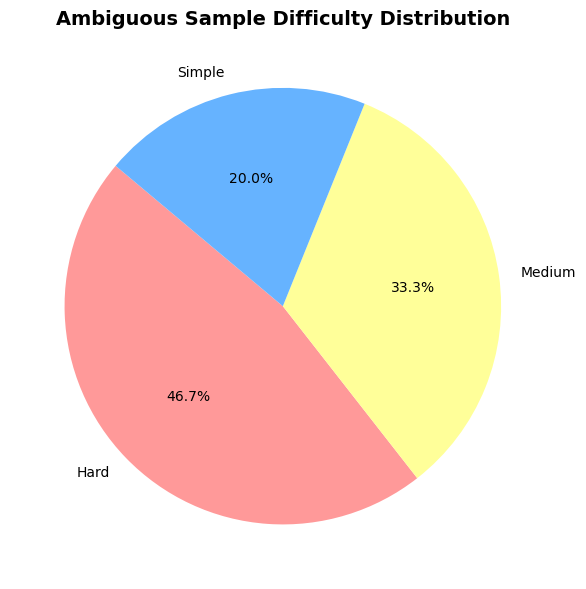

\n=== Method 1: Baseline (Zero-Shot) ===
--- Running Method 1: Baseline (Self-Correction) on 30 samples (n_shots=0) in Parallel ---
\n=== Method 1: Baseline (Few-Shot) ===
--- Running Method 1: Baseline (Self-Correction) on 30 samples (n_shots=3) in Parallel ---
\n=== Method 2: Sphinteract (Zero-Shot) ===
--- Running Method 2: Sphinteract on 30 samples (n_shots=0) in Parallel ---
\n=== Method 2: Sphinteract (Few-Shot) ===
--- Running Method 2: Sphinteract on 30 samples (n_shots=3) in Parallel ---
\n=== Method 3: Break No Ambiguity (Zero-Shot) ===
--- Running Method 3: Break No Ambiguity on 30 samples (n_shots=0) in Parallel ---
\n=== Method 3: Break No Ambiguity (Few-Shot) ===
--- Running Method 3: Break No Ambiguity on 30 samples (n_shots=3) in Parallel ---

--- Visualization of Results ---
Results saved to experiment_results.json
Reading results from experiment_results.json for plotting...
No data to visualize.


In [98]:
def visualize_results(res_m1_zero, res_m1_few, res_m2_zero, res_m2_few, res_m3_zero, res_m3_few, test_subset=None):
    print("\n--- Visualization of Results ---")
    
    # 1. Construct unified data structure & Save to JSON
    data_map = {
        'M1_Zero': res_m1_zero, 'M1_Few': res_m1_few,
        'M2_Zero': res_m2_zero, 'M2_Few': res_m2_few,
        'M3_Zero': res_m3_zero, 'M3_Few': res_m3_few
    }
    
    json_data = []
    for key, df in data_map.items():
        if df.empty: continue
        method, mode = key.split('_')
        records = df.to_dict(orient='records')
        for r in records:
            r['Method'] = method
            r['Mode'] = mode
            # Calculate status for stacked bar
            if r['is_correct']:
                if r.get('syntax_fix', False):
                    r['Status'] = 'Syntax Fix Correct'
                elif r.get('rounds', 0) == 0:
                    r['Status'] = 'Initial Correct'
                else:
                    r['Status'] = 'Interactive Correct'
            else:
                r['Status'] = 'Incorrect'
        json_data.extend(records)
        
    json_path = 'experiment_results.json'
    with open(json_path, 'w') as f:
        json.dump(json_data, f, indent=2, default=str)
    print(f"Results saved to {json_path}")
    
    # 2. Read from JSON for plotting (as requested)
    print(f"Reading results from {json_path} for plotting...")
    with open(json_path, 'r') as f:
        loaded_data = json.load(f)
    
    full_df = pd.DataFrame(loaded_data)
    
    if full_df.empty:
        print("No data to visualize.")
        return

    # Set Academic Style
    sns.set_theme(style="white")
    sns.set_context("paper", font_scale=1.2)
    
    # Define Palettes: M1=Blue, M2=Orange, M3=Green
    palette_dict = {'M1': '#4E79A7', 'M2': '#F28E2B', 'M3': '#59A14F'}
    
    # --- Figure 1: 2x2 Grid (Accuracy & Rounds) ---
    fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10))
    fig1.suptitle('Performance Overview', fontsize=16, fontweight='bold')
    
    modes = ['Zero', 'Few']
    agg_df = full_df.groupby(['Method', 'Mode']).agg(
        Accuracy=('is_correct', 'mean'),
        Avg_Rounds=('rounds', 'mean'),
        SyntaxFixCount=('syntax_fix', 'sum')
    ).reset_index()
    print("\nAggregated Performance Table (includes SyntaxFixCount):")
    print(agg_df.to_string(index=False))
    
    for i, mode in enumerate(modes):
        # Top Row: Accuracy
        ax_acc = axes1[0, i]
        subset = agg_df[agg_df['Mode'] == mode]
        if not subset.empty:
            sns.barplot(data=subset, x='Method', y='Accuracy', palette=palette_dict, ax=ax_acc)
            ax_acc.set_title(f'Accuracy ({mode}-shot)')
            ax_acc.set_ylim(0, 1.1)
            ax_acc.set_ylabel('Success Rate' if i==0 else '')
            for p in ax_acc.patches:
                ax_acc.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontweight='bold')

        # Bottom Row: Rounds
        ax_rds = axes1[1, i]
        if not subset.empty:
            sns.barplot(data=subset, x='Method', y='Avg_Rounds', palette=palette_dict, ax=ax_rds)
            ax_rds.set_title(f'Avg Interaction Rounds ({mode}-shot)')
            ax_rds.set_ylabel('Rounds' if i==0 else '')
            # Add values on top
            max_h = 0
            for p in ax_rds.patches:
                h = p.get_height()
                if h > max_h: max_h = h
                ax_rds.annotate(f'{h:.2f}', (p.get_x() + p.get_width() / 2., h),
                                ha='center', va='bottom', fontsize=10, fontweight='bold')
            ax_rds.set_ylim(0, max_h * 1.2 if max_h > 0 else 1) 

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # --- Figure 2: Stacked Bar Chart (Correctness Breakdown) ---
    breakdown_list = []
    for (method, mode), group in full_df.groupby(['Method', 'Mode']):
        total = len(group)
        initial = len(group[group['Status'] == 'Initial Correct'])
        interactive = len(group[group['Status'] == 'Interactive Correct'])
        syntaxfix = len(group[group['Status'] == 'Syntax Fix Correct'])
        incorrect = len(group[group['Status'] == 'Incorrect'])
        
        breakdown_list.append({'Method': method, 'Mode': mode, 'Type': 'Initial Correct', 'Prop': initial/total})
        breakdown_list.append({'Method': method, 'Mode': mode, 'Type': 'Interactive Correct', 'Prop': interactive/total})
        breakdown_list.append({'Method': method, 'Mode': mode, 'Type': 'Syntax Fix Correct', 'Prop': syntaxfix/total})
        breakdown_list.append({'Method': method, 'Mode': mode, 'Type': 'Incorrect', 'Prop': incorrect/total})
        
    breakdown_df = pd.DataFrame(breakdown_list)
    status_palette = {'Initial Correct': '#1f77b4', 'Interactive Correct': '#2ca02c', 'Syntax Fix Correct': '#17becf', 'Incorrect': '#d62728'}
    
    if not breakdown_df.empty:
        fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6))
        fig2.suptitle('Correctness Breakdown', fontsize=16, fontweight='bold')
        
        for i, mode in enumerate(modes):
            ax = axes2[i]
            subset = breakdown_df[breakdown_df['Mode'] == mode]
            if not subset.empty:
                pivot_df = subset.pivot(index='Method', columns='Type', values='Prop').fillna(0)
                # Ensure all columns exist
                for col in ['Initial Correct', 'Interactive Correct', 'Syntax Fix Correct', 'Incorrect']:
                    if col not in pivot_df.columns: pivot_df[col] = 0
                pivot_df = pivot_df[['Initial Correct', 'Interactive Correct', 'Syntax Fix Correct', 'Incorrect']]
                
                pivot_df.plot(kind='bar', stacked=True, color=[status_palette[c] for c in pivot_df.columns], ax=ax)
                ax.set_title(f'Breakdown ({mode}-shot)')
                ax.set_ylabel('Proportion' if i==0 else '')
                ax.set_ylim(0, 1.0)
                if i == 1:
                    ax.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
                else:
                    ax.get_legend().remove()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # --- Figure 3: Difficulty Distribution ---
    if test_subset is not None and 'difficulty' in test_subset.columns:
        plt.figure(figsize=(6, 6))
        diff_counts = test_subset['difficulty'].value_counts()
        colors_map = {'Hard': '#ff9999', 'Medium': '#ffff99', 'Simple': '#66b3ff'}
        pie_colors = [colors_map.get(l, '#cccccc') for l in diff_counts.index]
        
        plt.pie(diff_counts, labels=diff_counts.index, autopct='%1.1f%%', startangle=140, colors=pie_colors)
        plt.title('Test Sample Difficulty Distribution', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    

def select_test_samples(df, simple_n=5, medium_n=5, hard_n=30):
    # This function is replaced by ambiguity filtering
    return select_ambiguous_samples(df, target_n=30)

def select_ambiguous_samples(df, target_n=30):
    print(f"--- Selecting {target_n} Ambiguous Samples using GPT-3.5-Turbo ---")
    
    if 'sql_tok_len' not in df.columns:
        print("Calculating SQL token lengths...")
        df['sql_tok_len'] = df['sql'].apply(lambda x: len(x.split()))
        
    df['len'] = df['sql_tok_len']
    df_sorted = df.sort_values('len')
    
    # Define thresholds for difficulty (based on full dataset)
    n = len(df)
    t1 = n // 3
    t2 = 2 * n // 3
    
    simple_pool = df_sorted.iloc[:t1]
    medium_pool = df_sorted.iloc[t1:t2]
    hard_pool = df_sorted.iloc[t2:]
    
    def get_difficulty(length):
        if length >= hard_pool['len'].min(): return 'Hard'
        elif length >= medium_pool['len'].min(): return 'Medium'
        else: return 'Simple'
    
    selected_indices = []
    
    # Shuffle df to get random candidates
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    def check_ambiguity_row(row_tuple):
        idx, row = row_tuple
        nlq = row['nl']
        db_name = row['target_db'] if 'target_db' in row else row['db_id']
        schema = get_schema(db_name)
        
        prompt = f"""/* Given the following database schema: */
{schema}
/* And the following Natural Language Question: */
{nlq}

/* Task: Determine if the question is ambiguous given the schema.
   Ambiguity can arise from:
   - AmbQuestion: The question phrasing is unclear.
   - AmbTableColumn: Unclear mapping to tables/columns.
   - AmbOutput: Unclear what columns to output.
   - AmbValue: Unclear predicate values.

   Answer "Yes" if the question is ambiguous, or "No" if it is clear.
   Provide a brief reason.
*/
Is the question ambiguous? Answer: """
        # print(f"Checking sample {idx}...")
        amb_model = os.getenv("AMBIGUITY_MODEL", "gpt-4o-mini")
        response, _ = LLM_generation(prompt, model=amb_model, retries=5, retry_delay=2.0, log_each_retry=False)
        
        resp = response.strip()
        if resp.startswith("SELECT * FROM error") or resp.lower().startswith("error") or "bad gateway" in resp.lower():
            return idx, None, nlq
        is_ambiguous = False
        u = resp.upper()
        if u.startswith("YES") or "YES" in u[:5]:
            is_ambiguous = True
        return idx, is_ambiguous, nlq

    # Process in batches until target_n is reached
    candidates = list(df_shuffled.iterrows())
    total_candidates = len(candidates)
    current_idx = 0
    workers_env = os.getenv("AMBIGUITY_WORKERS", "8")
    try:
        max_workers = max(1, int(workers_env))
    except Exception:
        max_workers = 8
    batch_size = max_workers

    print(f"Searching for {target_n} ambiguous samples from {total_candidates} candidates...")

    while len(selected_indices) < target_n and current_idx < total_candidates:
        batch_end = min(current_idx + batch_size, total_candidates)
        batch_candidates = candidates[current_idx:batch_end]
        
        print(f"Checking batch {current_idx}-{batch_end} (Found: {len(selected_indices)}/{target_n})...")
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {executor.submit(check_ambiguity_row, c): c[0] for c in batch_candidates}
            
            error_count = 0
            reached = False
            for future in concurrent.futures.as_completed(futures):
                try:
                    idx, is_ambiguous, nlq = future.result()
                    if is_ambiguous is True:
                        print(f"  [Ambiguous] {nlq}")
                        selected_indices.append(idx)
                        if len(selected_indices) >= target_n:
                            reached = True
                            print(f"Reached target {target_n}; early stop.")
                            break
                    elif is_ambiguous is False:
                        print(f"  [Clear] {nlq}")
                    else:
                        print(f"  [Skipped: LLM error] {nlq}")
                        error_count += 1
                except Exception as e:
                    print("Error processing sample: LLM failure; skipped")
                    error_count += 1
            if error_count > (batch_size * 0.3):
                print("High LLM error rate in batch; pausing 10s before next batch...")
                time.sleep(10)
            if reached:
                break
        
        current_idx += batch_size

    selected_indices = selected_indices[:target_n]
    if len(selected_indices) < target_n:
        need = target_n - len(selected_indices)
        selected_set = set(selected_indices)
        hard_fill = [i for i in hard_pool.index.tolist() if i not in selected_set]
        medium_fill = [i for i in medium_pool.index.tolist() if i not in selected_set]
        simple_fill = [i for i in simple_pool.index.tolist() if i not in selected_set]
        filler = []
        for i in hard_fill:
            if len(filler) >= need:
                break
            filler.append(i)
        if len(filler) < need:
            for i in medium_fill:
                if len(filler) >= need:
                    break
                filler.append(i)
        if len(filler) < need:
            for i in simple_fill:
                if len(filler) >= need:
                    break
                filler.append(i)
        selected_indices = selected_indices + filler[:need]
            
    if not selected_indices:
        print("Warning: No ambiguous samples found. Returning random samples.")
        result = df.sample(target_n)
    else:
        result = df_shuffled.loc[selected_indices].copy()
        
    # Assign difficulty labels
    result['difficulty'] = result['len'].apply(get_difficulty)
    
    print(f"Selected {len(result)} samples.")
    # Print difficulty distribution
    print(result['difficulty'].value_counts())
    
    # Plot difficulty distribution
    plt.figure(figsize=(6, 6))
    diff_counts = result['difficulty'].value_counts()
    colors_map = {'Hard': '#ff9999', 'Medium': '#ffff99', 'Simple': '#66b3ff'}
    pie_colors = [colors_map.get(l, '#cccccc') for l in diff_counts.index]
    
    plt.pie(diff_counts, labels=diff_counts.index, autopct='%1.1f%%', startangle=140, colors=pie_colors)
    plt.title('Ambiguous Sample Difficulty Distribution', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return result

try:
    from IPython import get_ipython
    if get_ipython() is None:
        generate_notebook()
    else:
        print('Skipping notebook generation under Jupyter environment.')
except Exception:
    generate_notebook()
    print("\n--- Generating Notebook (reproduction_sphinteract_ambiguity_generated.ipynb) ---")
    nb = nbf.v4.new_notebook()
    
    text_intro = """# Reproduction of Sphinteract on KaggleDBQA (Ambiguity Filtered)

This notebook reproduces the three methods described in the paper "Sphinteract: ...":
1.  **Baseline (Method 1)**: Zero-shot generation with Self-Correction (Fix Invalid).
2.  **Sphinteract (Method 2)**: Interactive framework with Clarification Questions (SRA) and Feedback.
3.  **Break No Ambiguity (Method 3)**: Similar to Method 2 but with an Early Stopping mechanism.

We use the **KaggleDBQA** dataset.

**Modification**: Instead of random sampling, we filter for 20 "Ambiguous" samples using GPT-3.5-Turbo.

## Requirements
- `openai`
- `pandas`
- `sqlite3`
- `numpy`
- `python-dotenv`
- `tiktoken`
- `xxhash`

Ensure you have a `.env` file with `OPENAI_API_KEY` and `OPENAI_BASE_URL` (optional).
"""
    nb.cells.append(nbf.v4.new_markdown_cell(text_intro))
    
    # Read current file
    try:
        with open(__file__, 'r') as f:
            content = f.read()
    except NameError:
        # Fallback if __file__ is not defined (e.g. interactive)
        content = open('reproduce_sphinteract_ambiguity.py', 'r').read()
        
    # Split by separators
    separator = "# " + "-" * 78
    parts = content.split(separator)
    
    # Imports
    nb.cells.append(nbf.v4.new_code_cell(parts[0].strip()))
    
    for part in parts[1:]:
        if not part.strip(): continue
        
        lines = part.strip().split('\n')
        
        # Heuristic: If it's the main block, maybe mark it?
        if "if __name__ == \"__main__\":" in part:
             nb.cells.append(nbf.v4.new_markdown_cell("## Execution"))
        elif "Helper Functions" in lines[0]:
             nb.cells.append(nbf.v4.new_markdown_cell("## Helper Functions"))
        elif "Prompts" in lines[0]:
             nb.cells.append(nbf.v4.new_markdown_cell("## Prompts"))
        elif "Method" in lines[0]:
             nb.cells.append(nbf.v4.new_markdown_cell(f"## {lines[0].replace('# ', '').strip()}"))
        elif "Visualization" in lines[0]:
             nb.cells.append(nbf.v4.new_markdown_cell("## Visualization"))
             
        nb.cells.append(nbf.v4.new_code_cell(part.strip()))
        
    with open('reproduction_sphinteract_ambiguity_generated.ipynb', 'w') as f:
        nbf.write(nb, f)
    print("Notebook reproduction_sphinteract_ambiguity_generated.ipynb generated successfully.")

if __name__ == "__main__":
    # Generate the notebook representation of this script
    try:
        from IPython import get_ipython
        if get_ipython() is None:
            generate_notebook()
        else:
            print('Skipping notebook generation under Jupyter environment.')
    except Exception:
        generate_notebook()

    # 1. Select Shared Test Samples
    # Modified sample selection as per user request: Simple=5, Medium=5, Hard=30
    test_subset = select_test_samples(df)

    if len(test_subset) == 0:
        print("Warning: No samples found. Using first 30 samples.")
        test_subset = df.head(30)

    # 2. Run Experiments
    print("\\n=== Method 1: Baseline (Zero-Shot) ===")
    res_m1_zero = run_simple_feedback_experiment(test_subset, df, n_shots=0)

    print("\\n=== Method 1: Baseline (Few-Shot) ===")
    res_m1_few = run_simple_feedback_experiment(test_subset, df, n_shots=3)

    print("\\n=== Method 2: Sphinteract (Zero-Shot) ===")
    res_m2_zero = run_sphinteract_experiment(test_subset, df, n_shots=0)
    print("\\n=== Method 2: Sphinteract (Few-Shot) ===")
    res_m2_few = run_sphinteract_experiment(test_subset, df, n_shots=3)

    print("\\n=== Method 3: Break No Ambiguity (Zero-Shot) ===")
    res_m3_zero = run_break_no_ambiguity_experiment(test_subset, df, n_shots=0)

    print("\\n=== Method 3: Break No Ambiguity (Few-Shot) ===")
    res_m3_few = run_break_no_ambiguity_experiment(test_subset, df, n_shots=3)

    # 3. Visualize
    visualize_results(res_m1_zero, res_m1_few, res_m2_zero, res_m2_few, res_m3_zero, res_m3_few, test_subset=test_subset)

## Beatify Figures

In [99]:
def redraw_from_results(json_path='experiment_results.json', save_dir=None):
    import os, json, numpy as np, pandas as pd
    import matplotlib.pyplot as plt, seaborn as sns
    from matplotlib import colors as mcolors

    # 亮色生成：提高亮度，不改变透明度
    def lighten(c, factor=0.40):
        r, g, b = mcolors.to_rgb(c)
        return (1 - (1 - r) * (1 - factor),
                1 - (1 - g) * (1 - factor),
                1 - (1 - b) * (1 - factor))

    # 读取结果
    if not os.path.exists(json_path):
        raise FileNotFoundError(json_path)
    with open(json_path, 'r') as f:
        loaded = json.load(f)
    df = pd.DataFrame(loaded)
    if df.empty:
        raise ValueError('Empty results')

    # 全局更大字体与符号尺寸
    sns.set_theme(style='white')
    sns.set_context('talk', font_scale=1.6)  # 比 paper 1.2 大很多
    plt.rcParams.update({
        'figure.dpi': 160,
        'axes.titlesize': 18,
        'axes.titleweight': 'bold',
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.title_fontsize': 12,
        'legend.fontsize': 12,
        'axes.linewidth': 1.2,
        'lines.linewidth': 2.0,
        'patch.linewidth': 0.8,
        'grid.linewidth': 0.8,
    })

    # 颜色：Zero-shot 基础色；Few-shot 亮色（透明度不变）
    base_palette = {'M1': '#4E79A7', 'M2': '#F28E2B', 'M3': '#59A14F'}
    few_palette = {k: lighten(v, 0.40) for k, v in base_palette.items()}
    modes = ['Zero', 'Few']

    # 聚合指标
    agg = df.groupby(['Method', 'Mode']).agg(
        Accuracy=('is_correct', 'mean'),
        Avg_Rounds=('rounds', 'mean')
    ).reset_index()

    # 图 1：性能总览（普通柱状图），Few 使用亮色
    fig1, axes1 = plt.subplots(2, 2, figsize=(15, 10))
    fig1.suptitle('Performance Overview', fontsize=18, fontweight='bold')

    for i, mode in enumerate(modes):
        sub = agg[agg['Mode'] == mode]
        pal = base_palette if mode == 'Zero' else few_palette

        # Accuracy
        ax_acc = axes1[0, i]
        if not sub.empty:
            sns.barplot(data=sub, x='Method', y='Accuracy', palette=pal, ax=ax_acc)
            ax_acc.set_title(f'Accuracy ({mode}-shot)')
            ax_acc.set_ylim(0, 1.1)
            ax_acc.set_ylabel('Success Rate' if i == 0 else '')
            for p in ax_acc.patches:
                h = p.get_height()
                ax_acc.annotate(f'{h:.2f}', (p.get_x() + p.get_width()/2., h),
                                ha='center', va='center', xytext=(0, 8), textcoords='offset points',
                                fontsize=12, fontweight='bold')

        # Avg Rounds
        ax_rds = axes1[1, i]
        if not sub.empty:
            sns.barplot(data=sub, x='Method', y='Avg_Rounds', palette=pal, ax=ax_rds)
            ax_rds.set_title(f'Avg Interaction Rounds ({mode}-shot)')
            ax_rds.set_ylabel('Rounds' if i == 0 else '')
            max_h = 0
            for p in ax_rds.patches:
                h = p.get_height()
                max_h = max(max_h, h)
                ax_rds.annotate(f'{h:.2f}', (p.get_x() + p.get_width()/2., h),
                                ha='center', va='bottom', fontsize=12, fontweight='bold')
            ax_rds.set_ylim(0, max_h * 1.25 if max_h > 0 else 1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fig1.savefig(os.path.join(save_dir, 'performance_overview.png'), dpi=160)
    plt.show()

    # 图 2：正确性分解（累积柱状图，分段比例标签）
    status_order = ['Initial Correct', 'Interactive Correct', 'Syntax Fix Correct', 'Incorrect']
    status_palette = {'Initial Correct': '#1f77b4', 'Interactive Correct': '#2ca02c',
                      'Syntax Fix Correct': '#17becf', 'Incorrect': '#d62728'}

    breakdown = []
    for (m, md), grp in df.groupby(['Method', 'Mode']):
        t = len(grp)
        vals = {s: (len(grp[grp['Status'] == s]) / t if t else 0) for s in status_order}
        for s in status_order:
            breakdown.append({'Method': m, 'Mode': md, 'Type': s, 'Prop': vals[s]})
    bdf = pd.DataFrame(breakdown)

    fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))
    fig2.suptitle('Correctness Breakdown', fontsize=18, fontweight='bold')

    methods = ['M1', 'M2', 'M3']
    x = np.arange(len(methods))
    width = 0.6

    for i, mode in enumerate(modes):
        ax = axes2[i]
        sub = bdf[bdf['Mode'] == mode]
        if sub.empty:
            continue
        pivot = sub.pivot(index='Method', columns='Type', values='Prop').reindex(
            index=methods, columns=status_order).fillna(0)

        bottoms = np.zeros(len(methods))
        bars_info = []
        for s in status_order:
            h = pivot[s].values
            b = ax.bar(x, h, width, bottom=bottoms, color=status_palette[s], label=s)
            bars_info.append((s, h, bottoms, b))
            bottoms = bottoms + h

        ax.set_xticks(x)
        ax.set_xticklabels(methods)
        ax.set_ylim(0, 1.0)
        ax.set_ylabel('Proportion' if i == 0 else '')
        ax.set_title(f'Breakdown ({mode}-shot)')

        # 每个分段的比例标签
        for s, h, btm, b in bars_info:
            for j in range(len(h)):
                val = h[j]
                if val > 0.02:
                    y = btm[j] + val / 2
                    lbl = f'{val:.0%}'
                    ax.text(x[j], y, lbl, ha='center', va='center',
                            fontsize=12, fontweight='bold',
                            color='#000000' if val < 0.25 else '#ffffff')

        if i == 1:
            ax.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            leg = ax.get_legend()
            if leg is not None:
                leg.remove()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fig2.savefig(os.path.join(save_dir, 'correctness_breakdown.png'), dpi=160)
    plt.show()

In [100]:

# 确认文件存在与记录数
import os, json
print(os.path.exists('experiment_results.json'))
with open('experiment_results.json') as f:
    print(len(json.load(f)))

# 直接重绘（并保存）
redraw_from_results('experiment_results.json', save_dir='./figs')

True
0


ValueError: Empty results

In [101]:
# === 交互式调试/演示工具 (Interactive Debugging Tools) ===
import inspect
import functools
import os
import sqlite3

def debug_wrapper(func):
    """
    装饰器：打印函数的输入参数和输出结果，帮助理解每一步的数据变换。
    Decorator: Prints function inputs and outputs to help understand data transformations at each step.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        print(f"\n{'='*20} 正在调用 (Calling) {func.__name__} {'='*20}")
        
        # 1. 打印输入 (Print Inputs)
        sig = inspect.signature(func)
        try:
            bound_args = sig.bind(*args, **kwargs)
            bound_args.apply_defaults()
            print(">> 输入参数 (Inputs):")
            for k, v in bound_args.arguments.items():
                val_str = str(v)
                # 截断过长的输出 (Truncate long outputs)
                if len(val_str) > 500: val_str = val_str[:500] + "... (truncated)"
                print(f"   - {k}: {val_str}")
        except Exception as e:
            print(f"   (参数解析失败: {e})")
            
        # 2. 模拟断点 (Optional Breakpoint)
        # 取消下行注释可以在每一步暂停等待回车 (Uncomment below to pause at each step)
        # input(">> 按回车键继续执行 (Press Enter to continue)...") 
        
        # 3. 执行函数 (Execute)
        try:
            result = func(*args, **kwargs)
            
            # 4. 打印输出 (Print Output)
            res_str = str(result)
            if len(res_str) > 500: res_str = res_str[:500] + "... (truncated)"
            print(f">> 执行结果 (Output) -> {res_str}")
            return result
        except Exception as e:
            print(f">> 发生异常 (Exception) -> {e}")
            raise e
        finally:
            print(f"{'='*20} 结束 (End) {func.__name__} {'='*20}\n")
    return wrapper

def run_debug_demo():
    """
    运行一个完整的 Text2SQL 流程演示，展示数据在各个函数间的流动。
    Runs a full Text2SQL flow demo to show data flow between functions.
    """
    print("🚀 开始调试演示 (Starting Debug Demo)...")
    
    # A. 准备测试环境：创建一个临时数据库 (Setup Dummy DB)
    db_path = "debug_demo.db"
    if os.path.exists(db_path):
        os.remove(db_path)
    
    # 创建表并插入数据
    conn = sqlite3.connect(db_path)
    conn.execute("CREATE TABLE users (id INTEGER PRIMARY KEY, name TEXT, age INTEGER, role TEXT)")
    conn.execute("INSERT INTO users (name, age, role) VALUES ('Alice', 30, 'admin'), ('Bob', 25, 'user'), ('Charlie', 35, 'user')")
    conn.commit()
    conn.close()
    
    # B. 包装现有函数 (Wrap existing functions)
    # 注意：这些函数需要在 notebook 前面的单元格中已定义
    # Note: These functions must be defined in previous cells
    debug_generate_schema = debug_wrapper(generate_db_schema)
    debug_clean_query = debug_wrapper(clean_query)
    
    # 模拟 LLM (Mock LLM) 以避免 API 调用
    # 真实场景中你可以替换为 debug_wrapper(LLM_generation)
    @debug_wrapper
    def mock_llm_generation(prompt):
        print("   (模拟 LLM 思考中... Generating SQL...)")
        return "", 0.0

    # C. 执行流程 (Execute Flow)
    
    # Step 1: 提取 Schema
    print("\n--- [Step 1] 提取数据库结构 (Extract Schema) ---")
    schema = debug_generate_schema(db_path)
    
    # Step 2: 生成 SQL
    print("\n--- [Step 2] 模型生成 SQL (Generate SQL) ---")
    user_question = "Find all users older than 20."
    prompt = f"Question: {user_question}\nSchema: {schema}"
    raw_sql_output, cost = mock_llm_generation(prompt)
    
    # Step 3: 清洗 SQL
    print("\n--- [Step 3] 清洗 SQL (Clean SQL) ---")
    cleaned_sql = debug_clean_query(raw_sql_output)
    
    # Step 4: 验证/执行 (Evaluate)
    print("\n--- [Step 4] 执行与验证 (Evaluate) ---")
    # 这里我们直接执行看看结果
    try:
        conn = sqlite3.connect(db_path)
        res = conn.execute(cleaned_sql).fetchall()
        print(f"   查询执行结果: {res}")
        conn.close()
    except Exception as e:
        print(f"   执行失败: {e}")

    # 清理文件
    if os.path.exists(db_path):
        os.remove(db_path)
    print("\n✅ 演示结束 (Demo Finished).")

# 运行演示
run_debug_demo()


🚀 开始调试演示 (Starting Debug Demo)...

--- [Step 1] 提取数据库结构 (Extract Schema) ---

==================== 正在调用 (Calling) generate_db_schema ====================
>> 输入参数 (Inputs):
   - db_path: debug_demo.db
>> 执行结果 (Output) -> CREATE TABLE users (id INTEGER PRIMARY KEY, name TEXT, age INTEGER, role TEXT)
==================== 结束 (End) generate_db_schema ====================


--- [Step 2] 模型生成 SQL (Generate SQL) ---

==================== 正在调用 (Calling) mock_llm_generation ====================
>> 输入参数 (Inputs):
   - prompt: Question: Find all users older than 20.
Schema: CREATE TABLE users (id INTEGER PRIMARY KEY, name TEXT, age INTEGER, role TEXT)
   (模拟 LLM 思考中... Generating SQL...)
>> 执行结果 (Output) -> ('', 0.0)
==================== 结束 (End) mock_llm_generation ====================


--- [Step 3] 清洗 SQL (Clean SQL) ---

==================== 正在调用 (Calling) clean_query ====================
>> 输入参数 (Inputs):
   - sql_query: 
>> 执行结果 (Output) -> SELECT
==================== 结束 (End) clean_query ==

In [ ]:
import os, sqlite3, functools, inspect, re

def debug_wrapper(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        print(f"\n=== Calling {func.__name__} ===")
        try:
            sig = inspect.signature(func)
            bound = sig.bind(*args, **kwargs)
            bound.apply_defaults()
            print("Inputs:")
            for k,v in bound.arguments.items():
                s = str(v)
                if len(s) > 500: s = s[:500] + "..."
                print(f" - {k}: {s}")
        except Exception as e:
            print(f" (Signature parse failed: {e})")
        try:
            out = func(*args, **kwargs)
            s = str(out)
            if len(s) > 500: s = s[:500] + "..."
            print(f"Output: {s}")
            return out
        except Exception as e:
            print(f"Exception: {e}")
            raise
        finally:
            print(f"=== End {func.__name__} ===")
    return wrapper


def compose_zero_shot_prompt(nlq, schema):
    meta = build_metadata_constraints(nlq, schema)
    return sql_generation_selfdebug.format(schema=schema, sqls="", metadata=meta, question=nlq)


def compose_few_shot_prompt(nlq, schema, exemplars):
    ex_snippets = "\n".join([f"/* example NLQ: {e['nlq']} */\n/* example SQL: {e['sql']} */" for e in exemplars])
    meta = build_metadata_constraints(nlq, schema)
    return sql_generation_v2.format(schema=schema, sqls=ex_snippets, cqas="", metadata=meta, question=nlq)


def safe_llm(prompt, **kwargs):
    try:
        return LLM_generation(prompt, **kwargs)
    except Exception as e:
        print(f"LLM failed ({e}); using mock.")
        return "```sql\nSELECT name FROM users WHERE role='user' AND age > 20\n```", 0.0


def setup_demo_db(db_path):
    if os.path.exists(db_path):
        os.remove(db_path)
    conn = sqlite3.connect(db_path)
    conn.execute("CREATE TABLE users (id INTEGER PRIMARY KEY, name TEXT, age INTEGER, role TEXT)")
    conn.execute("INSERT INTO users (name, age, role) VALUES ('Alice', 30, 'admin')")
    conn.execute("INSERT INTO users (name, age, role) VALUES ('Bob', 25, 'user')")
    conn.execute("INSERT INTO users (name, age, role) VALUES ('Charlie', 35, 'user')")
    conn.commit()
    conn.close()


def zero_shot_flow():
    print("\n--- Zero-shot Full Flow ---")
    db_path = "zero_few_demo.db"
    setup_demo_db(db_path)

    dbg_schema = debug_wrapper(generate_db_schema)
    schema = dbg_schema(db_path)

    nlq = "List names of users with role='user' older than 20"
    dbg_compose_zero = debug_wrapper(compose_zero_shot_prompt)
    prompt = dbg_compose_zero(nlq, schema)

    dbg_llm = debug_wrapper(safe_llm)
    raw_sql, cost = dbg_llm(prompt, model='gpt-3.5-turbo', temperature=0.0)

    dbg_clean = debug_wrapper(clean_query)
    cleaned_sql = dbg_clean(raw_sql)

    gold_sql = "SELECT name FROM users WHERE role='user' AND age > 20"
    print("Compare source vs gold (exec results):")
    ok, errs = evalfunc(cleaned_sql, gold_sql, db_path)
    print(f"Equal: {ok}; Errors: {errs}")

    os.remove(db_path)


def few_shot_flow():
    print("\n--- Few-shot Full Flow ---")
    db_path = "zero_few_demo.db"
    setup_demo_db(db_path)

    schema = generate_db_schema(db_path)

    exemplars = [
        {"nlq": "Find user names older than 30", "sql": "SELECT name FROM users WHERE age > 30"},
        {"nlq": "Count admins", "sql": "SELECT COUNT(*) FROM users WHERE role='admin'"}
    ]

    prompt = compose_few_shot_prompt("List names of users with role='user' older than 20", schema, exemplars)

    raw_sql, cost = safe_llm(prompt, model='gpt-3.5-turbo', temperature=0.0)
    cleaned_sql = clean_query(raw_sql)

    gold_sql = "SELECT name FROM users WHERE role='user' AND age > 20"
    ok, errs = evalfunc(cleaned_sql, gold_sql, db_path)
    print(f"Equal: {ok}; Errors: {errs}")

    os.remove(db_path)

zero_shot_flow()
few_shot_flow()



--- Zero-shot Full Flow ---


NameError: name 'generate_db_schema' is not defined